# TCS iON Industry Honour Course - Application of Deep Learning and Neural Networks
# Industry Assignment - 2
## Amazon Reviews Text Classification using CNN & LSTM
Name : Jaymin Mistry

College: B.K.Birla College of Arts, Science and Commerce, Kalyan

### Importing Necessary Libraries

Before we begin, we need to import libraries which we will use in our code.

In [ ]:
import pandas as pd
from numpy import array, asarray, zeros
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input, Attention, LSTM
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

### Data Preparation

Now we mount Google Drive as it contains our dataset and other important files which we will use shortly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

After mounting the Drive we will now read the csv file which contains the Amazon reviews.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reviews.csv')
df.head()

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


In this data we only need the `ReviewBody` and `ReviewStar` columns. So we will drop the remaining columns.

In [ ]:
df.drop(['ReviewTitle', 'Product'], axis=1, inplace=True)
df.head()

,ReviewBody,ReviewStar
0,No doubt it has a great bass and to a great ex...,3
1,"This earphones are unreliable, i bought it be...",1
2,"i bought itfor 999,I purchased it second time,...",4
3,Its sound quality is adorable. overall it was ...,1
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5


Now we will see whether our data has any missing values in it. We will also examine the datatype of the columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ReviewBody  14337 non-null  object
 1   ReviewStar  14337 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 224.1+ KB


So our data has `14337` rows in it and no missing values. Let us now check the frequency distribution of the review ratings.

In [ ]:
df['ReviewStar'].value_counts()

5    6213
4    3189
1    2493
3    1503
2     939
Name: ReviewStar, dtype: int64

Looks like our dataset has majority of positive reviews. We don't need exact ratings for our task, we just need whether the review is positive or negative. So we will consider reviews with ratings `5` and `4` as `positive` and reviews with ratings `1` and `2` as `negative`. We will remove all the reviews with rating `3` as it resembles `neutral` sentiment.

In [ ]:
# Remove rows with value 3
df = df[df['ReviewStar'] != 3]

# Create a new column with the coded values
df['labels'] = df['ReviewStar'].map({1: 0, 2: 0, 4: 1, 5: 1})

# Drop the original 'ReviewStar' column
df.drop(['ReviewStar'], axis=1, inplace=True)
df.head()

# Rename the column
df = df.rename(columns={'ReviewBody': 'review_text'})

# Change order of columns
df = df[['labels', 'review_text']]

So `1` is positive and `0` is negative. Now we will check their distribution.

In [ ]:
df['labels'].value_counts()

1    9402
0    3432
Name: labels, dtype: int64

When it comes to classification we need balanced datasets ie. labels should have uniform distribution. So we create a new dataframe where we take all the negative reviews and sample some positive reviews to create a balanced dataset.

In [ ]:
df = pd.concat([df[df['labels'] == 1].sample(3432, random_state=100), df[df['labels'] == 0]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6864 entries, 1044 to 14336
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   labels       6864 non-null   int64 
 1   review_text  6864 non-null   object
dtypes: int64(1), object(1)
memory usage: 160.9+ KB


In [ ]:
df = df.reset_index(drop=True)
df.head()

,labels,review_text
0,1,I got a already opened package. The product is...
1,1,Battery life is awesome\n
2,1,I like it.\n
3,1,Good packaging and crystal clear sound..for ba...
4,1,Earphone is good but it do not have in build m...


Now let us see whether the dataset is balanced.

In [ ]:
df['labels'].value_counts()

1    3432
0    3432
Name: labels, dtype: int64

Both the classes have equal reviews. Now that our dataset is balanced let us now move to processing of the text data.

In [ ]:
docs = df['review_text'].tolist()
labels = df['labels'].to_numpy()

First we will tokenize our reviews and see how many unique words are there in the reviews.

In [ ]:
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
print(vocab_size)

7639


Our reviews have `7639` unique words. Now we need to convert our words into numbers so that model can train on it. We will convert them into sequences where these sequences are numerical representations of the original texts and each word has been replaced by its index in the tokenizer's vocabulary.

In [ ]:
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs[0])

[4, 73, 15, 394, 922, 455, 2, 10, 1, 21, 205, 77, 44, 6, 4, 151, 28, 276, 5, 4, 68, 75, 5, 151, 1471, 12, 170, 42, 4, 102, 6, 803, 2, 247, 40, 11, 394, 106, 225, 91, 23, 243, 232, 33, 323, 38, 2, 2149, 35, 578, 10]


We can see one such sequence in the output. Now these sequences are of varying lengths so we need to convert them into sequences with same length to make our data consistent. We will do so by padding these sequences with 0.

In [ ]:
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs[0])

[   4   73   15  394  922  455    2   10    1   21  205   77   44    6
    4  151   28  276    5    4   68   75    5  151 1471   12  170   42
    4  102    6  803    2  247   40   11  394  106  225   91   23  243
  232   33  323   38    2 2149   35  578   10    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


We can see one such sequence in the output. Our data is now ready.

### Model Training

Now we will import GloVe embeddings which contains the words and their numerical vector representations. In traditional models we need to clean data further with processes like Stemming, Lemmatization, removal of stop words & punctuations etc. but while using pre-trained embeddings we can skip these steps and still achieve reasonable outputs.

In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.6B.100d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


We will now populate an `embedding_matrix` with pre-trained word embeddings for the words present in our dataset. It checks if a word in our dataset exists in the pre-trained embeddings and, if so, uses that embedding to fill the matrix at the corresponding index. This matrix will be used as the initial embeddings for the words in our dataset during model training.

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
  embedding_matrix[i] = embedding_vector

Let us now split the dataset into training and test sets. We will perform an 80-20 split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2, random_state=100)

We will also set some additional parameters which will be required in model training.

In [ ]:
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 100

First we will train a CNN Model and see how it performs. This CNN architecture is suitable for text data, utilizing pre-trained word embeddings, multiple convolutional layers, regularization techniques, and specific configuration for training the model efficiently and combatting overfitting.

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))

# Reduced number of filters and kernel sizes to lower complexity
filters = 64
kernel_size = 3

model.add(Conv1D(filters, kernel_size, padding='same', activation='relu'))
model.add(MaxPooling1D())

# Implement Dropout and BatchNormalization after each Convolutional layer
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv1D(filters, kernel_size, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv1D(filters, kernel_size, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

# Regularization with L2 regularization on the Dense layer
hidden_dims = 64
model.add(Dense(hidden_dims, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# Reduce learning rate and add momentum to the optimizer to reduce overfitting
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

After defining the architecture let us train the model.

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=75,
          validation_data=(X_test, y_test))

Epoch 1/75
172/172 [==============================] - 13s 20ms/step - loss: 1.9941 - accuracy: 0.5008 - val_loss: 1.7603 - val_accuracy: 0.5040
Epoch 2/75
172/172 [==============================] - 2s 12ms/step - loss: 1.8509 - accuracy: 0.4908 - val_loss: 1.6438 - val_accuracy: 0.5076
Epoch 3/75
172/172 [==============================] - 3s 15ms/step - loss: 1.7076 - accuracy: 0.5196 - val_loss: 1.5442 - val_accuracy: 0.5186
Epoch 4/75
172/172 [==============================] - 3s 15ms/step - loss: 1.6263 - accuracy: 0.5116 - val_loss: 1.4598 - val_accuracy: 0.5339
Epoch 5/75
172/172 [==============================] - 2s 14ms/step - loss: 1.5181 - accuracy: 0.5469 - val_loss: 1.3904 - val_accuracy: 0.5462
Epoch 6/75
172/172 [==============================] - 2s 13ms/step - loss: 1.4437 - accuracy: 0.5489 - val_loss: 1.3301 - val_accuracy: 0.5790
Epoch 7/75
172/172 [==============================] - 2s 9ms/step - loss: 1.3784 - accuracy: 0.5555 - val_loss: 1.2764 - val_accuracy: 0.5812

43/43 - 0s - loss: 0.2981 - accuracy: 0.8966 - 125ms/epoch - 3ms/step


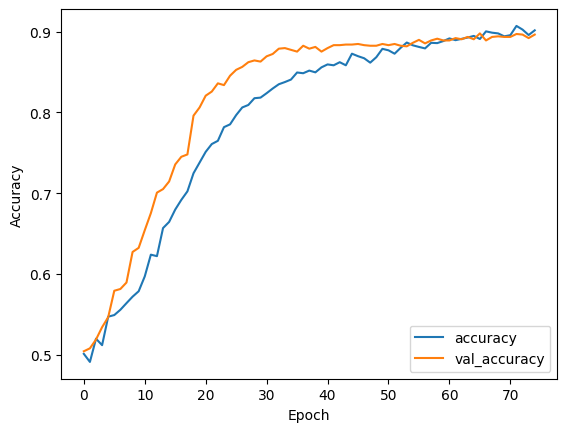

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Looking at the diagram we can say that our model is trained perfectly fine. Both the train accuracy and validation accuracy are almost equal.

In [ ]:
print(test_acc)

0.8965768218040466


Our CNN model produced an accuracy of `0.896` which is quite good. Now we will train a LSTM model with attention networks. This architecture leverages LSTM, known for its ability to model sequence data, along with an attention mechanism, providing the network the capability to focus on crucial parts of the sequences.

In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dims, input_length=max_length)(input_layer)

lstm_layer = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

# Attention Mechanism
attention = Attention()([lstm_layer, lstm_layer])

# Flatten or Pool over time dimension before passing to Dense layers
flatten_layer = Flatten()(attention)

dense_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flatten_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Let us now train the model.

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(X_test, y_test))

Epoch 1/5
172/172 [==============================] - 162s 909ms/step - loss: 0.7461 - accuracy: 0.5504 - val_loss: 0.5366 - val_accuracy: 0.8296
Epoch 2/5
172/172 [==============================] - 136s 790ms/step - loss: 0.4392 - accuracy: 0.8463 - val_loss: 0.3659 - val_accuracy: 0.8762
Epoch 3/5
172/172 [==============================] - 141s 824ms/step - loss: 0.3328 - accuracy: 0.9029 - val_loss: 0.3258 - val_accuracy: 0.8791
Epoch 4/5
172/172 [==============================] - 133s 774ms/step - loss: 0.2920 - accuracy: 0.9179 - val_loss: 0.3225 - val_accuracy: 0.8718
Epoch 5/5
172/172 [==============================] - 133s 774ms/step - loss: 0.2650 - accuracy: 0.9290 - val_loss: 0.3899 - val_accuracy: 0.8937


43/43 - 2s - loss: 0.3899 - accuracy: 0.8937 - 2s/epoch - 41ms/step


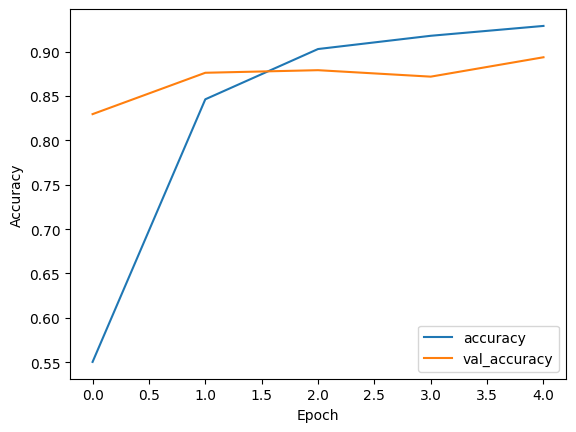

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

This model trains relatively quickly compared to our earlier CNN model in terms of epochs taken. In the diagram we can see both the train and validation accuracy are almost equal, which is a good sign for our model.

In [ ]:
print(test_acc)

0.8936635255813599


Our LSTM model with Attention mechanism produced accuracy of `0.893` which is very good.

### Conclusion

In this notebook, we explored how to prepare text data for computers to understand. We began by converting words into numbers using a tool called a `Tokenizer`. This helped turn our text into sequences of numbers, making it easier for computers to work with.

Then, we introduced pre-existing word patterns that the computer already understood. It was like giving the computer a head start in understanding the text. These patterns were like shortcuts for the computer.

After data preparation, we trained 2 models: `CNN` and `LSTM`. Both the models gave `0.89` accuracy and did not overfit.